In [1]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset, Balltest
from model import Model
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json

In [2]:
!nvidia-smi

Thu Mar  7 14:31:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:37:00.0 Off |                    0 |
| N/A   75C    P0            252W /  250W |   23692MiB /  40960MiB |    100%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [15]:
data_set = BallDataset()
# data_set = BallDataset("ellipse/uniform_samples_80.json")
# data_set = DAVIS_Seq2(is_one_video=True)
# test_set = Balltest("ellipse/uniform_samples_80.json")
test_set = Balltest()

batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [13]:
pre_frame, curr_frame, pre_boundary, curr_boundary, idx = next(iter(data_loader))

In [6]:
idx

tensor([1])

In [7]:
pre_frame.shape

torch.Size([1, 3, 224, 224])

Text(0.5, 1.0, 'Select Frame')

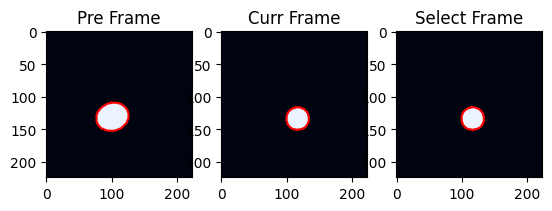

In [14]:
index = 0
plt.subplot(1, 3, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 3, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')
plt.subplot(1, 3, 3)
plt.imshow(normalize_image(test_set[idx][0].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Select Frame')


In [7]:
model = Model()

/zhome/32/f/202284/CV/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
def chamer_distance_loss(x, y):
    def bi_chamfer_distance(x, y):
        def chamfer_distance(a: torch.Tensor, b: torch.Tensor) -> float:
            total_min_dist = 0
            for i in range(a.shape[0]):
                total_min_dist += (b - a[i]).pow(2).sum(1).min(0)[0]
            return total_min_dist / a.shape[0]
        return chamfer_distance(x, y) + chamfer_distance(y, x)

    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += bi_chamfer_distance(x[i], y[i])

    return result / x.shape[0]

predict_boundary = pre_boundary.clone()
predict_boundary[:, :, 0] += 9
predict_boundary[:, :, 1] += -5
# print(curr_boundary - pre_boundary)
chamer_distance_loss(
    curr_boundary.float(),
    (predict_boundary).float()
)

tensor(172.0875)

In [9]:
pre_boundary.shape, curr_boundary.shape

(torch.Size([1, 80, 2]), torch.Size([1, 80, 2]))

In [10]:
def order_loss(x: torch.Tensor, y: torch.Tensor):
    def my_order_loss(x, y):
        min_loss = (x - y).abs().sum()
        for shift in range(1, x.shape[0]):
            # loss = (x - torch.roll(y, shifts=shift, dims=0)).pow(2).sum().sqrt()
            loss = (x - torch.roll(y, shifts=shift, dims=0)).abs().sum()
            min_loss = torch.min(min_loss, loss)
        return min_loss / x.shape[0]
        # return min_loss
        
    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_order_loss(x[i], y[i])

    return result / x.shape[0]
predict_boundary = pre_boundary.clone()
predict_boundary[:, :, 0] += 8
predict_boundary[:, :, 1] += -5
order_loss(curr_boundary, predict_boundary)

tensor(17.9125)

In [11]:
torch.cuda.empty_cache()

In [12]:
model = model.cuda()
output = model(pre_frame.to("cuda"), curr_frame.to("cuda"), pre_boundary.to("cuda")).cpu()
predic_boundary = output + pre_boundary
chamer_distance_loss(predic_boundary, curr_boundary.float())

tensor(43.9452, grad_fn=<DivBackward0>)

In [37]:
model = Model().to('cuda')
model_name = "uniform_model"
data_set = BallDataset()
# data_set = BallDataset("ellipse/uniform_samples_80.json")
# data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
# loss_name = "chamer_distance_loss"
loss_name = "order_loss"
if loss_name == "chamer_distance_loss":
    loss_func = chamer_distance_loss
else:
    loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [38]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

0.6654949188232422

In [39]:
dict_loss = {}
num_epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
min_loss = 1e10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
for e in range(num_epochs):
    model.train()
    mean_loss = 0
    for pre_frame, curr_frame, pre_boundary, curr_boundary in tqdm(data_loader):
        pre_frame, curr_frame, pre_boundary, curr_boundary = (
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        optimizer.zero_grad()
        output = model(pre_frame, curr_frame, pre_boundary)
        predic_boundary = output + pre_boundary
        loss = loss_func(predic_boundary, curr_boundary.float())
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        loss.backward()
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"./models/{model_name}_{loss_name}.pth")
        mean_loss += loss.item()
    mean_loss /= len(data_loader)
    dict_loss[e] = mean_loss
    scheduler.step()
    print(f"Epoch {e + 1}, Loss: {mean_loss}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.53s/it]


Epoch 1, Loss: 10.979840538718484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 2, Loss: 6.348078164187345


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]


Epoch 3, Loss: 3.3261818885803223


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.36it/s]


Epoch 4, Loss: 1.4516300450671802


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.52it/s]


Epoch 5, Loss: 1.0995951728387312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.92it/s]


Epoch 6, Loss: 0.9826621792533181


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.90it/s]


Epoch 7, Loss: 0.9385323524475098


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.07it/s]


Epoch 8, Loss: 0.9297118457880887


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.80it/s]


Epoch 9, Loss: 0.9227270646528765


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.51it/s]


Epoch 10, Loss: 0.9288221814415671


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.65it/s]


Epoch 11, Loss: 0.8817961324344982


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.77it/s]


Epoch 12, Loss: 0.8839958472685381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.66it/s]


Epoch 13, Loss: 0.8847823576493696


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.71it/s]


Epoch 14, Loss: 0.8646126606247642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.70it/s]


Epoch 15, Loss: 0.8427939252419905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.00it/s]


Epoch 16, Loss: 0.8534224304285917


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.89it/s]


Epoch 17, Loss: 0.8401349457827482


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.71it/s]


Epoch 18, Loss: 0.8526528098366477


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.70it/s]


Epoch 19, Loss: 0.8551840619607405


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.05it/s]


Epoch 20, Loss: 0.8347325270826166


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.06it/s]


Epoch 21, Loss: 0.8504409139806574


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.55it/s]


Epoch 22, Loss: 0.838914459401911


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.35it/s]


Epoch 23, Loss: 0.8284938335418701


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.29it/s]


Epoch 24, Loss: 0.8252210075205023


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.86it/s]


Epoch 25, Loss: 0.8246386863968589


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.33it/s]


Epoch 26, Loss: 0.8387667211619291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.95it/s]


Epoch 27, Loss: 0.8303382830186323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.06it/s]


Epoch 28, Loss: 0.8333076509562406


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.68it/s]


Epoch 29, Loss: 0.8206745873798024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.43it/s]


Epoch 30, Loss: 0.8326856331391768


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.67it/s]


Epoch 31, Loss: 0.8409699255769904


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.60it/s]


Epoch 32, Loss: 0.8081594109535217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.77it/s]


Epoch 33, Loss: 0.834875079718503


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.68it/s]


Epoch 34, Loss: 0.8253728909925981


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.09it/s]


Epoch 35, Loss: 0.826278957453641


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.80it/s]


Epoch 36, Loss: 0.8270123655145819


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.81it/s]


Epoch 37, Loss: 0.8320101716301658


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.84it/s]


Epoch 38, Loss: 0.8284065452488986


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.63it/s]


Epoch 39, Loss: 0.8271216587586836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.76it/s]


Epoch 40, Loss: 0.8368301879275929


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.71it/s]


Epoch 41, Loss: 0.8233765092763033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.03it/s]


Epoch 42, Loss: 0.8290813077579845


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.75it/s]


Epoch 43, Loss: 0.833360108462247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.82it/s]


Epoch 44, Loss: 0.8374622951854359


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.93it/s]


Epoch 45, Loss: 0.820647884498943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.67it/s]


Epoch 46, Loss: 0.8345063653859225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.92it/s]


Epoch 47, Loss: 0.8184780532663519


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.94it/s]


Epoch 48, Loss: 0.8229452967643738


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.52it/s]


Epoch 49, Loss: 0.8180540908466686


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.74it/s]


Epoch 50, Loss: 0.8299735080112111


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.67it/s]


Epoch 51, Loss: 0.8304717594927008


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.68it/s]


Epoch 52, Loss: 0.8324835679747842


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.60it/s]


Epoch 53, Loss: 0.8208636316386136


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.74it/s]


Epoch 54, Loss: 0.82780968059193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.52it/s]


Epoch 55, Loss: 0.8235219635746696


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.58it/s]


Epoch 56, Loss: 0.8375037800181996


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.57it/s]


Epoch 57, Loss: 0.8179836923425848


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.03it/s]


Epoch 58, Loss: 0.8307768377390775


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.73it/s]


Epoch 59, Loss: 0.8206554326144132


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.42it/s]


Epoch 60, Loss: 0.8323514678261497


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.32it/s]


Epoch 61, Loss: 0.8186462033878673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.91it/s]


Epoch 62, Loss: 0.8133381442590193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.89it/s]


Epoch 63, Loss: 0.8187509287487377


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.87it/s]


Epoch 64, Loss: 0.8206676678224043


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.56it/s]


Epoch 65, Loss: 0.8281511989506808


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.12it/s]


Epoch 66, Loss: 0.8291435837745667


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.44it/s]


Epoch 67, Loss: 0.8411519473249262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.54it/s]


Epoch 68, Loss: 0.8224556987935846


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.05it/s]


Epoch 69, Loss: 0.8142156059091742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.59it/s]


Epoch 70, Loss: 0.8284163691780784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.51it/s]


Epoch 71, Loss: 0.8100947087461298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.82it/s]


Epoch 72, Loss: 0.8275252472270619


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.74it/s]


Epoch 73, Loss: 0.8221517151052301


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.84it/s]


Epoch 74, Loss: 0.825218525799838


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.01it/s]


Epoch 75, Loss: 0.8609520955519243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.13it/s]


Epoch 76, Loss: 0.8358534357764504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.29it/s]


Epoch 77, Loss: 0.8331353230909868


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.71it/s]


Epoch 78, Loss: 0.817217696796764


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.76it/s]


Epoch 79, Loss: 0.8141224546865984


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.12it/s]


Epoch 80, Loss: 0.8344130461866205


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.62it/s]


Epoch 81, Loss: 0.8188248357989572


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.76it/s]


Epoch 82, Loss: 0.8258289369669828


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.64it/s]


Epoch 83, Loss: 0.8296203477816149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.07it/s]


Epoch 84, Loss: 0.8321719169616699


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.51it/s]


Epoch 85, Loss: 0.8459037108854814


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.88it/s]


Epoch 86, Loss: 0.8320554603229869


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.72it/s]


Epoch 87, Loss: 0.8273082402619448


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.02it/s]


Epoch 88, Loss: 0.8332314057783647


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.75it/s]


Epoch 89, Loss: 0.8507380377162587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.60it/s]


Epoch 90, Loss: 0.832180378111926


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.65it/s]


Epoch 91, Loss: 0.8114011721177534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.41it/s]


Epoch 92, Loss: 0.8177450895309448


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.43it/s]


Epoch 93, Loss: 0.8207302310250022


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.51it/s]


Epoch 94, Loss: 0.8153529383919456


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.25it/s]


Epoch 95, Loss: 0.8171769055453214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.27it/s]


Epoch 96, Loss: 0.8231777548789978


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.41it/s]


Epoch 97, Loss: 0.834951866756786


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.43it/s]


Epoch 98, Loss: 0.8154135996645148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.47it/s]


Epoch 99, Loss: 0.8308565616607666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.29it/s]

Epoch 100, Loss: 0.8260655890811573


In [40]:
# save loss
with open(f"./log/{model_name}_{loss_name}.json", "w") as f:
    json.dump(dict_loss, f)

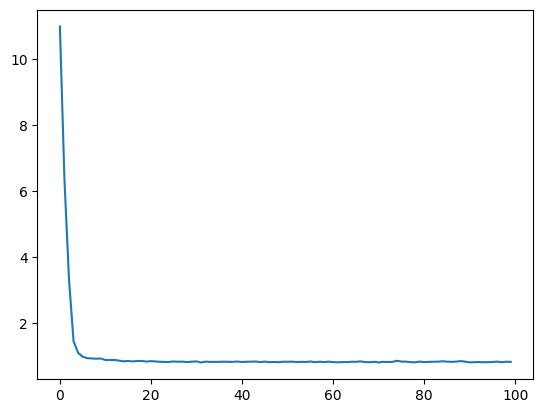

In [41]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))

In [53]:
model = Model()
model_name = "uniform_model"
# model_name = "simplify_model"
# loss_name = "order_loss"
loss_name = "chamer_distance_loss"
model.load_state_dict(torch.load(f"./models/{model_name}_{loss_name}.pth"))
model = model.to("cuda")

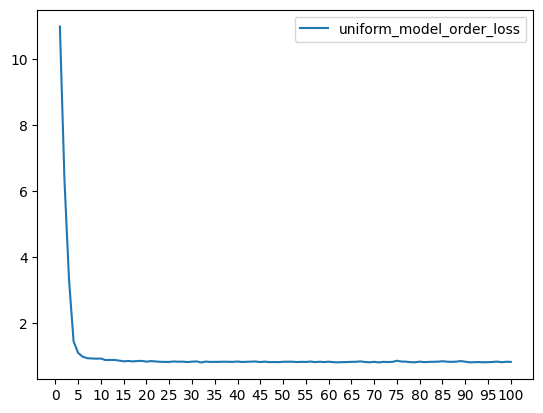

In [42]:
# load the loss
with open(f"./log/{model_name}_{loss_name}.json", "r") as f:
    dict_loss = json.load(f)
# plot the loss
plt.plot(np.array(list(dict_loss.keys())).astype(int) + 1, list(dict_loss.values()), label=f"{model_name}_{loss_name}")
# plt.legend(loc="lower right")
plt.legend()
# set the xticks
plt.xticks(np.arange(0, 101, 5))
plt.show()

In [43]:
class DAVIS_test(torch.utils.data.Dataset):
    def __init__(self, video_name: str, is_uniform=True):
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        if is_uniform:
            with open("./uniform_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        else:
            with open("./simplify_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        
        self.data = tmp_data[video_name]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, sgm_path, boundary = self.data[idx]
        img = Image.open(img_path)
        sgm = get_gray_image(sgm_path)
        img = self.transform(img)
        boundary = np.array(boundary).astype(np.int32)
        boundary = torch.tensor(boundary).int()
        return img, sgm, boundary

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.82it/s]


0.6921684282249898

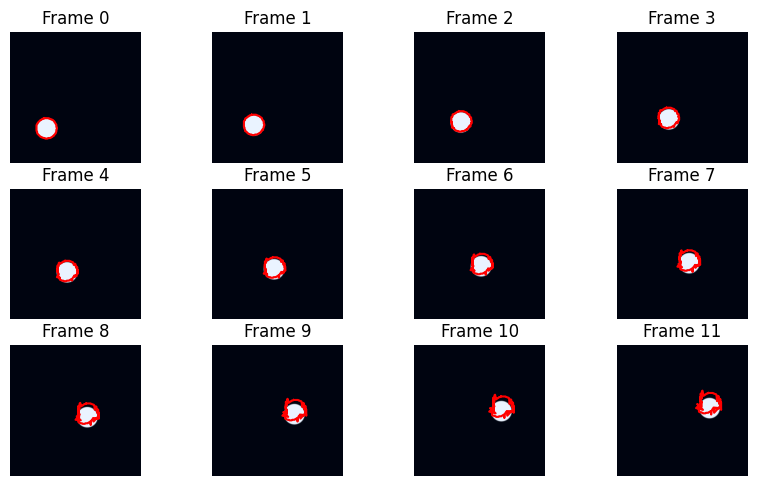

In [43]:
def test_model_one_video(model, test_dataset: torch.utils.data.Dataset, device="cuda"):
    pre_img, pre_sgm, pre_boundary = test_dataset[0]
    plt.figure(figsize=(10, 20))
    plt.subplot(10, 4, 1)
    plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
    plt.plot(pre_boundary[:, 0], pre_boundary[:, 1], 'r')
    plt.axis('off')
    plt.title('Frame 0')
    pre_boundary = pre_boundary.to(device)
    total_iou = 0
    model.eval()
    interval = 1
    for i in tqdm(range(1, len(test_dataset))):
        img, sgm, boundary = test_dataset[i]
        # print(pre_img.shape, img.shape, pre_boundary.shape)
        with torch.no_grad():
            boundary_offset = model(
                pre_img.unsqueeze(0).to(device),
                img.unsqueeze(0).to(device),
                pre_boundary.unsqueeze(0).to(device),
            )
            # pre_boundary[:, 0] += 9
            # print(boundary_offset)
            pre_boundary = pre_boundary + boundary_offset.squeeze(0)
            pre_boundary = pre_boundary.int()
            pre_boundary = torch.clamp(pre_boundary, 0, 223)
            # print(pre_boundary.cpu() - boundary)
            # pre_boundary = boundary.squeeze(0).to(device)
            pre_img = img
            if i % interval == 0:
                plt.subplot(10, 4, i // interval + 1)
                # plt.subplot(4, 4, i // interval)
                plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
                # index = 10
                # plt.scatter(pre_boundary.cpu().numpy()[:, 0][index], pre_boundary.cpu().numpy()[:, 1][index], )
                plt.plot(pre_boundary.cpu().numpy()[:, 0], pre_boundary.cpu().numpy()[:, 1], "r")
                plt.axis('off')
                plt.title(f'Frame {i}')
        total_iou += get_boundary_iou(sgm, pre_boundary.cpu().numpy())
    return total_iou / (len(test_dataset) - 1)
# if model_name == "uniform_model":
#     test_dataset = DAVIS_test("bear", is_uniform=True)
# else:
#     test_dataset = DAVIS_test("bear", is_uniform=False)
test_dataset = Balltest()
# test_dataset = Balltest("ellipse/uniform_samples_80.json")
test_model_one_video(model, test_dataset)